# Integrating Project Notebook

In this notebook, we will compare the different times each kernel will have and compare them with each other. The 4 kernels we have are the following:

- CPU kernel implemented using `C++`
- CPU kernel implemented using `Python`
- GPU kernel implemented using `CUDA C++`
- Optimized GPU kernel imeplemented using `CUDA C++`

Group members:
- Carandang, Matthew Ryan
- Veracruz, Sean Riley
- Yap, Rafael Subo

## Fetching the image where we will apply the filter

In [1]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

--2025-11-24 19:11:52--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 462.73K  --.-KB/s    in 0.02s   

2025-11-24 19:11:52 (20.9 MB/s) - ‘test.jpg’ saved [473831/473831]



## Installation of Dependencies

In [2]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import subprocess
import re
import os
from IPython.display import Image, display

In [3]:
!apt-get update
!apt-get install -y libopencv-dev

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [38.5 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:13 http://archive.ubuntu.com/ubuntu 

## Visualization of image without a filter

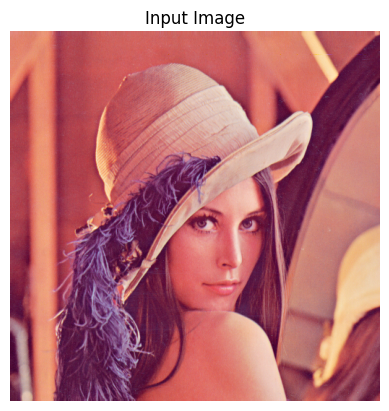

In [4]:
img = cv2.imread('test.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Input Image")
plt.axis('off')
plt.show()

## C++ Implementation

In [5]:
%%writefile kuwahara_cpu.cpp
#include <opencv2/opencv.hpp>
#include <iostream>
#include <chrono>
#include <vector>
#include <cmath>
#include <iomanip>

using namespace cv;
using namespace std;

void kuwaharaFilter(const Mat& src, Mat& dst, int kernelSize) {
    int radius = kernelSize / 2;

    // Create padded image to handle borders
    Mat padded;
    copyMakeBorder(src, padded, radius, radius, radius, radius, BORDER_REFLECT);

    // Initialize destination
    dst = Mat::zeros(src.size(), src.type());

    // Loop through every pixel
    for (int y = 0; y < src.rows; y++) {
        for (int x = 0; x < src.cols; x++) {

            float minVar = 1e9f;
            Vec3b bestMean = {0,0,0};

            // 4 Quadrants relative to center (x,y)
            // Format: {x_start, x_end, y_start, y_end}
            int ranges[4][4] = {
                {-radius, 0, -radius, 0}, // top left
                {0, radius, -radius, 0},  // top right
                {-radius, 0, 0, radius},  // bottom left
                {0, radius, 0, radius}    // bottom right
            };

            for (int k = 0; k < 4; k++) {
                float meanR = 0, meanG = 0, meanB = 0;
                float varR = 0, varG = 0, varB = 0;
                int count = 0;

                // iterate sub-region
                for (int dy = ranges[k][2]; dy <= ranges[k][3]; dy++) {
                    for (int dx = ranges[k][0]; dx <= ranges[k][1]; dx++) {
                        // Access pixel in Padded image
                        Vec3b p = padded.at<Vec3b>(y + radius + dy, x + radius + dx);

                        meanB += p[0];
                        meanG += p[1];
                        meanR += p[2];

                        varB += p[0] * p[0];
                        varG += p[1] * p[1];
                        varR += p[2] * p[2];

                        count++;
                    }
                }

                meanR /= count; meanG /= count; meanB /= count;
                varR = (varR / count) - (meanR * meanR);
                varG = (varG / count) - (meanG * meanG);
                varB = (varB / count) - (meanB * meanB);

                float totalVar = varR + varG + varB;

                if (totalVar < minVar) {
                    minVar = totalVar;
                    bestMean = {(uchar)meanB, (uchar)meanG, (uchar)meanR};
                }
            }
            dst.at<Vec3b>(y, x) = bestMean;
        }
    }
}

int main(int argc, char** argv) {
    if (argc < 3) {
        cerr << "Usage: ./kuwahara_cpu <image_path> <kernel_size>" << endl;
        return -1;
    }

    string inputPath = argv[1];
    int kernelSize = atoi(argv[2]);

    // IMREAD_COLOR ensures we get 3 channels (B,G,R) preventing segfaults on grayscale inputs
    Mat src = imread(inputPath, IMREAD_COLOR);

    if (src.empty()) {
        cerr << "ERROR: Could not find or open image at: " << inputPath << endl;
        return -1;
    }

    Mat dst;

    auto start = chrono::high_resolution_clock::now();
    kuwaharaFilter(src, dst, kernelSize);
    auto end = chrono::high_resolution_clock::now();

    chrono::duration<double, milli> duration = end - start;

    // print specifically formatted tag for Python
    cout << "CPU_TIME:" << duration.count() << endl;

    if (imwrite("cpu-cpp-output.jpg", dst)) {
        cerr << "Image saved to cpu-cpp-output.jpg" << endl;
    } else {
        cerr << "ERROR: Failed to save output image." << endl;
        return -1;
    }

    return 0;
}

Writing kuwahara_cpu.cpp


In [6]:
!g++ kuwahara_cpu.cpp -o kuwahara_cpu $(pkg-config --cflags --libs opencv4)

In [7]:
!./kuwahara_cpu test.jpg 7

CPU_TIME:1084.71
Image saved to cpu-cpp-output.jpg


## Python Implementation

In [8]:
import numpy as np
import cv2

def kuwahara_python(image, kernel_size=5):
    """
    Vectorized Python implementation matching the C++ Kuwahara logic.
    """
    # Ensure image is float for precision during calculation
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    src = image.astype(np.float32)

    radius = (kernel_size - 1) // 2

    window_size = radius + 1

    anchors = [
        (window_size - 1, window_size - 1), # Bottom-Right
        (0, window_size - 1),               # Bottom-Left
        (window_size - 1, 0),               # Top-Right
        (0, 0)                              # Top-Left
    ]

    means = []
    variances = []

    # Pre-calculate square of image for variance: Var = E[x^2] - (E[x])^2
    src_sq = src ** 2

    for anchor in anchors:
        # Compute Mean (E[x]) for this quadrant
        mean = cv2.boxFilter(src, -1, (window_size, window_size), anchor=anchor,
                             normalize=True, borderType=cv2.BORDER_REFLECT)

        # Compute Mean of Squares (E[x^2]) for this quadrant
        mean_sq = cv2.boxFilter(src_sq, -1, (window_size, window_size), anchor=anchor,
                                normalize=True, borderType=cv2.BORDER_REFLECT)

        # 3. Variance = E[x^2] - (E[x])^2
        variance = mean_sq - mean ** 2

        # Sum variance across B, G, R channels
        total_variance = np.sum(variance, axis=2)

        means.append(mean)
        variances.append(total_variance)

    variances_stack = np.stack(variances, axis=-1)

    # Find index of the quadrant with lowest variance for each pixel
    best_idx = np.argmin(variances_stack, axis=-1)

    filtered = np.zeros_like(src)
    for i in range(4):
        mask = (best_idx == i)
        filtered[mask] = means[i][mask]

    return filtered.astype(np.uint8)

## GPU Implementation

In [9]:
%%writefile kuwahara_gpu.cu

#include <opencv2/opencv.hpp>
#include <iostream>
#include <cuda_runtime.h>
#include <vector>

using namespace cv;
using namespace std;

// macro for error
#define cudaCheckError(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true) {
   if (code != cudaSuccess) {
      fprintf(stderr,"GPU Error: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

// cuda kernel
__global__ void kuwaharaShared(unsigned char* src, unsigned char* dst, int width, int height, int radius) {
    extern __shared__ unsigned char smem[];

    int sm_width = blockDim.x + 2 * radius;
    int tile_top_left_x = blockIdx.x * blockDim.x - radius;
    int tile_top_left_y = blockIdx.y * blockDim.y - radius;

    int total_sm_pixels = sm_width * (blockDim.y + 2 * radius);
    int threads_per_block = blockDim.x * blockDim.y;
    int thread_id_linear = threadIdx.y * blockDim.x + threadIdx.x;

    // load global memory to shared memory
    for (int i = thread_id_linear; i < total_sm_pixels; i += threads_per_block) {
        int local_y = i / sm_width;
        int local_x = i % sm_width;
        int global_y = tile_top_left_y + local_y;
        int global_x = tile_top_left_x + local_x;
        int sm_idx = i * 3;

        if (global_x >= 0 && global_x < width && global_y >= 0 && global_y < height) {
            int global_idx = (global_y * width + global_x) * 3;
            smem[sm_idx] = src[global_idx];
            smem[sm_idx+1] = src[global_idx+1];
            smem[sm_idx+2] = src[global_idx+2];
        } else {
            // Padding with zeros (or could replicate border)
            smem[sm_idx] = 0; smem[sm_idx+1] = 0; smem[sm_idx+2] = 0;
        }
    }

    __syncthreads();

    // Compute Kuwahara
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int sm_center_x = threadIdx.x + radius;
        int sm_center_y = threadIdx.y + radius;

        float minVariance = 1e9;
        float bestMean[3] = {0, 0, 0};

        // 4 sub-windows relative to the center pixel
        int ranges[4][4] = {
            {-radius, 0, -radius, 0}, // Top left
            {0, radius, -radius, 0},  // T op right
            {-radius, 0, 0, radius},  // Bottom left
            {0, radius, 0, radius}    // Bottom right
        };

        for (int k = 0; k < 4; k++) {
            float s[3] = {0,0,0};
            float ss[3] = {0,0,0};
            int count = 0;

            for (int dy = ranges[k][2]; dy <= ranges[k][3]; dy++) {
                for (int dx = ranges[k][0]; dx <= ranges[k][1]; dx++) {
                    int sy = sm_center_y + dy;
                    int sx = sm_center_x + dx;
                    int idx = (sy * sm_width + sx) * 3;

                    for(int c=0; c<3; c++) {
                        float val = smem[idx+c];
                        s[c] += val;
                        ss[c] += val * val;
                    }
                    count++;
                }
            }

            float mean[3], var[3], totVar = 0;
            for(int c=0; c<3; c++) {
                mean[c] = s[c] / count;
                var[c] = (ss[c] / count) - (mean[c] * mean[c]);
                totVar += var[c];
            }

            if (totVar < minVariance) {
                minVariance = totVar;
                for(int c=0; c<3; c++) bestMean[c] = mean[c];
            }
        }

        int outIdx = (y * width + x) * 3;
        dst[outIdx] = (unsigned char)bestMean[0];
        dst[outIdx+1] = (unsigned char)bestMean[1];
        dst[outIdx+2] = (unsigned char)bestMean[2];
    }
}

int main(int argc, char** argv) {
    if (argc < 3) {
        fprintf(stderr, "Usage: ./kuwahara_gpu <image> <size>\n");
        return -1;
    }

    string inputPath = argv[1];
    int kernelSize = atoi(argv[2]);
    int radius = kernelSize / 2; // Derived radius

    Mat img = imread(inputPath, IMREAD_COLOR);
    if (img.empty()) {
        fprintf(stderr, "Error reading image\n");
        return -1;
    }

    int width = img.cols;
    int height = img.rows;
    size_t size = width * height * 3;

    unsigned char *d_src, *d_dst;
    cudaMallocManaged(&d_src, size);
    cudaMallocManaged(&d_dst, size);

    // copy data to unified memory
    if (img.isContinuous()) {
        memcpy(d_src, img.data, size);
    } else {
        for (int i = 0; i < height; ++i)
            memcpy(d_src + i * width * 3, img.ptr(i), width * 3);
    }

    cudaDeviceSynchronize();

    dim3 block(16, 16);
    dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
    // Shared memory needs to hold the block + padding on all sides
    size_t smemSize = (block.x + 2*radius) * (block.y + 2*radius) * 3;

    kuwaharaShared<<<grid, block, smemSize>>>(d_src, d_dst, width, height, radius);
    cudaDeviceSynchronize();

    // timing process
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    kuwaharaShared<<<grid, block, smemSize>>>(d_src, d_dst, width, height, radius);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    // output for python:
    cout << "GPU_TIME:" << milliseconds << endl;

    // copy back and save
    Mat result(height, width, CV_8UC3);
    memcpy(result.data, d_dst, size);

    // write output image
    string outputPath = "gpu-cuda-output.jpg";
    imwrite(outputPath, result);
    cout << "Saved filtered image to: " << outputPath << endl;

    cudaFree(d_src);
    cudaFree(d_dst);
    return 0;
}

Writing kuwahara_gpu.cu


In [10]:
!nvcc -arch=sm_75 kuwahara_gpu.cu -o kuwahara_gpu $(pkg-config --cflags --libs opencv4)

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [11]:
!./kuwahara_gpu test.jpg 7

GPU_TIME:0.221696
Saved filtered image to: gpu-cuda-output.jpg


## Optimized CUDA implementation

In [12]:
%%writefile kuwahara_gpu_optimized.cu

#include <opencv2/opencv.hpp>
#include <iostream>
#include <cuda_runtime.h>
#include <vector>

using namespace cv;
using namespace std;

// error checking macro
#define cudaCheckError(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true) {
   if (code != cudaSuccess) {
      fprintf(stderr,"GPU Error: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

// CUDA Kernel using Shared Memory
__global__ void kuwaharaShared(unsigned char* src, unsigned char* dst, int width, int height, int radius) {
    extern __shared__ unsigned char smem[];

    int sm_width = blockDim.x + 2 * radius;
    int tile_top_left_x = blockIdx.x * blockDim.x - radius;
    int tile_top_left_y = blockIdx.y * blockDim.y - radius;

    int total_sm_pixels = sm_width * (blockDim.y + 2 * radius);
    int threads_per_block = blockDim.x * blockDim.y;
    int thread_id_linear = threadIdx.y * blockDim.x + threadIdx.x;

    // load Global Memory to Shared Memory
    for (int i = thread_id_linear; i < total_sm_pixels; i += threads_per_block) {
        int local_y = i / sm_width;
        int local_x = i % sm_width;
        int global_y = tile_top_left_y + local_y;
        int global_x = tile_top_left_x + local_x;
        int sm_idx = i * 3;

        if (global_x >= 0 && global_x < width && global_y >= 0 && global_y < height) {
            int global_idx = (global_y * width + global_x) * 3;
            smem[sm_idx] = src[global_idx];
            smem[sm_idx+1] = src[global_idx+1];
            smem[sm_idx+2] = src[global_idx+2];
        } else {
            // Padding with zeros
            smem[sm_idx] = 0; smem[sm_idx+1] = 0; smem[sm_idx+2] = 0;
        }
    }

    __syncthreads();

    // compute Kuwahara
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int sm_center_x = threadIdx.x + radius;
        int sm_center_y = threadIdx.y + radius;

        float minVariance = 1e9;
        float bestMean[3] = {0, 0, 0};

        // 4 sub-windows relative to the center pixel
        int ranges[4][4] = {
            {-radius, 0, -radius, 0}, // Top Left
            {0, radius, -radius, 0},  // Top Right
            {-radius, 0, 0, radius},  // Bottom Left
            {0, radius, 0, radius}    // Bottom Right
        };

        for (int k = 0; k < 4; k++) {
            float s[3] = {0,0,0};
            float ss[3] = {0,0,0};
            int count = 0;

            for (int dy = ranges[k][2]; dy <= ranges[k][3]; dy++) {
                for (int dx = ranges[k][0]; dx <= ranges[k][1]; dx++) {
                    int sy = sm_center_y + dy;
                    int sx = sm_center_x + dx;
                    int idx = (sy * sm_width + sx) * 3;

                    for(int c=0; c<3; c++) {
                        float val = smem[idx+c];
                        s[c] += val;
                        ss[c] += val * val;
                    }
                    count++;
                }
            }

            float mean[3], var[3], totVar = 0;
            for(int c=0; c<3; c++) {
                mean[c] = s[c] / count;
                var[c] = (ss[c] / count) - (mean[c] * mean[c]);
                totVar += var[c];
            }

            if (totVar < minVariance) {
                minVariance = totVar;
                for(int c=0; c<3; c++) bestMean[c] = mean[c];
            }
        }

        int outIdx = (y * width + x) * 3;
        dst[outIdx] = (unsigned char)bestMean[0];
        dst[outIdx+1] = (unsigned char)bestMean[1];
        dst[outIdx+2] = (unsigned char)bestMean[2];
    }
}

int main(int argc, char** argv) {
    if (argc < 3) {
        fprintf(stderr, "Usage: ./kuwahara_gpu <image> <size>\n");
        return -1;
    }

    string inputPath = argv[1];
    int kernelSize = atoi(argv[2]);
    int radius = kernelSize / 2;

    Mat img = imread(inputPath, IMREAD_COLOR);
    if (img.empty()) {
        fprintf(stderr, "Error reading image\n");
        return -1;
    }

    int width = img.cols;
    int height = img.rows;
    size_t size = width * height * 3;

    // 1. Get Device ID for Prefetching
    int device = -1;
    cudaGetDevice(&device);

    unsigned char *d_src, *d_dst;
    cudaMallocManaged(&d_src, size);
    cudaMallocManaged(&d_dst, size);

    // memadvice
    cudaMemAdvise(d_src, size, cudaMemAdviseSetReadMostly, device);


    if (img.isContinuous()) {
        memcpy(d_src, img.data, size);
    } else {
        for (int i = 0; i < height; ++i)
            memcpy(d_src + i * width * 3, img.ptr(i), width * 3);
    }

    // prefetch
    cudaMemPrefetchAsync(d_src, size, device, NULL);

    cudaMemPrefetchAsync(d_dst, size, device, NULL);

    dim3 block(16, 16);
    dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
    size_t smemSize = (block.x + 2*radius) * (block.y + 2*radius) * 3;

    kuwaharaShared<<<grid, block, smemSize>>>(d_src, d_dst, width, height, radius);
    cudaDeviceSynchronize();

    // Timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    kuwaharaShared<<<grid, block, smemSize>>>(d_src, d_dst, width, height, radius);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    cout << "GPU_TIME:" << milliseconds << endl;

    //prefetch
    cudaMemPrefetchAsync(d_dst, size, cudaCpuDeviceId, NULL);
    cudaDeviceSynchronize(); // Ensure prefetch is done before CPU access

    // copy and save
    Mat result(height, width, CV_8UC3);
    memcpy(result.data, d_dst, size);

    string outputPath = "gpu-optimizedcuda-output.jpg";
    imwrite(outputPath, result);
    // cout << "Saved filtered image to: " << outputPath << endl;

    cudaFree(d_src);
    cudaFree(d_dst);
    return 0;
}

Writing kuwahara_gpu_optimized.cu


In [13]:
!nvcc -arch=sm_75 kuwahara_gpu_optimized.cu -o kuwahara_gpu_optimized $(pkg-config --cflags --libs opencv4)

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [14]:
!./kuwahara_gpu_optimized test.jpg 7

GPU_TIME:0.217088


## Visualizing the test image with the output images from the different kernels

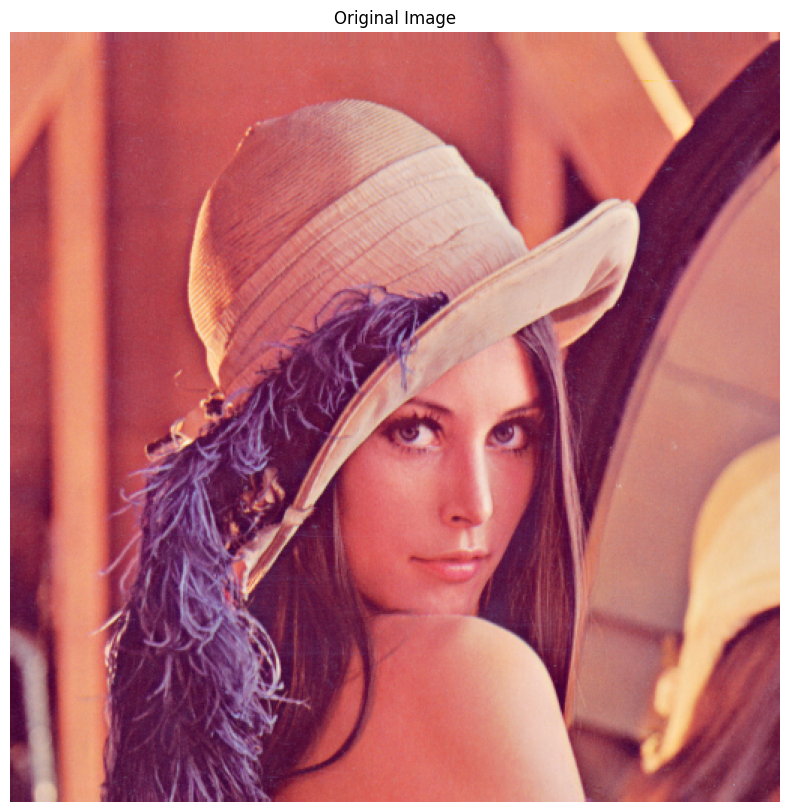

In [15]:
filtered = cv2.imread('test.jpg')
filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(filtered)
plt.axis('off')
plt.show()

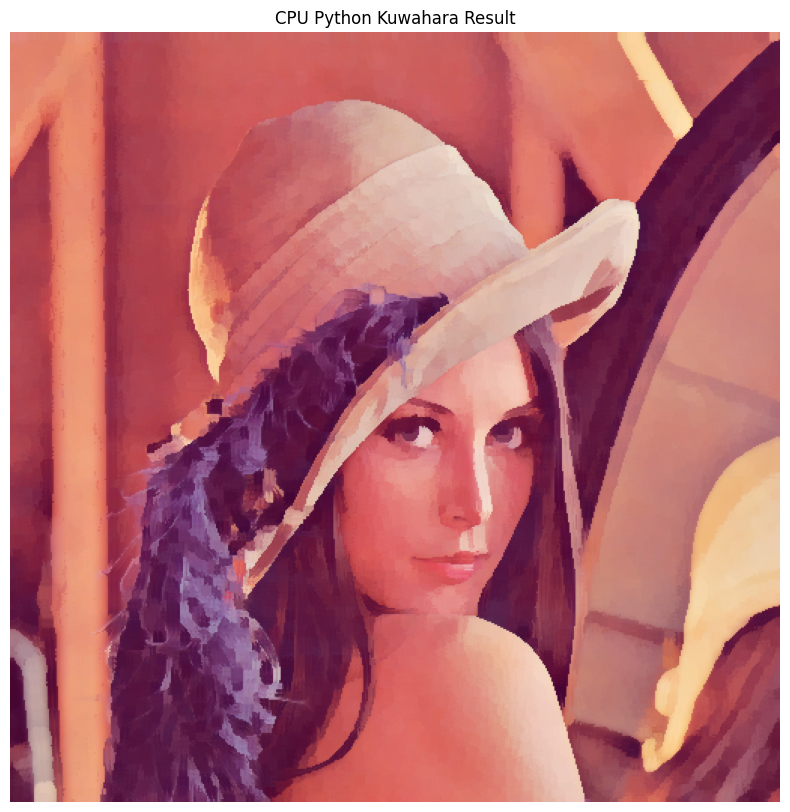

In [16]:
filtered = kuwahara_python(img, kernel_size=7)
filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title("CPU Python Kuwahara Result")
plt.imshow(filtered)
plt.axis('off')
plt.show()

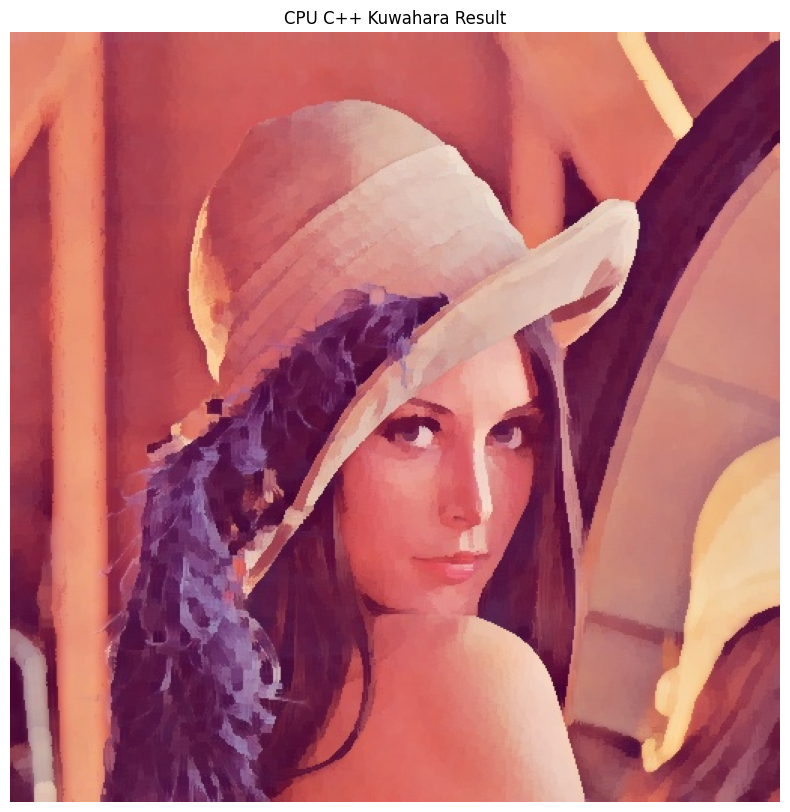

In [17]:
filtered = cv2.imread('cpu-cpp-output.jpg')
filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title("CPU C++ Kuwahara Result")
plt.imshow(filtered)
plt.axis('off')
plt.show()

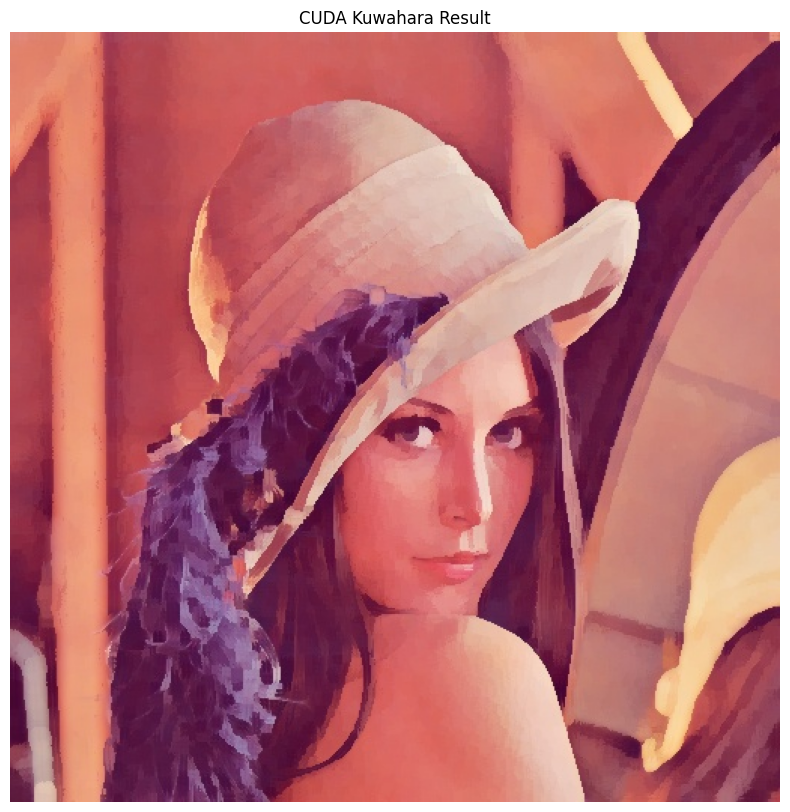

In [18]:
filtered = cv2.imread('gpu-cuda-output.jpg')
filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title("CUDA Kuwahara Result")
plt.imshow(filtered)
plt.axis('off')
plt.show()

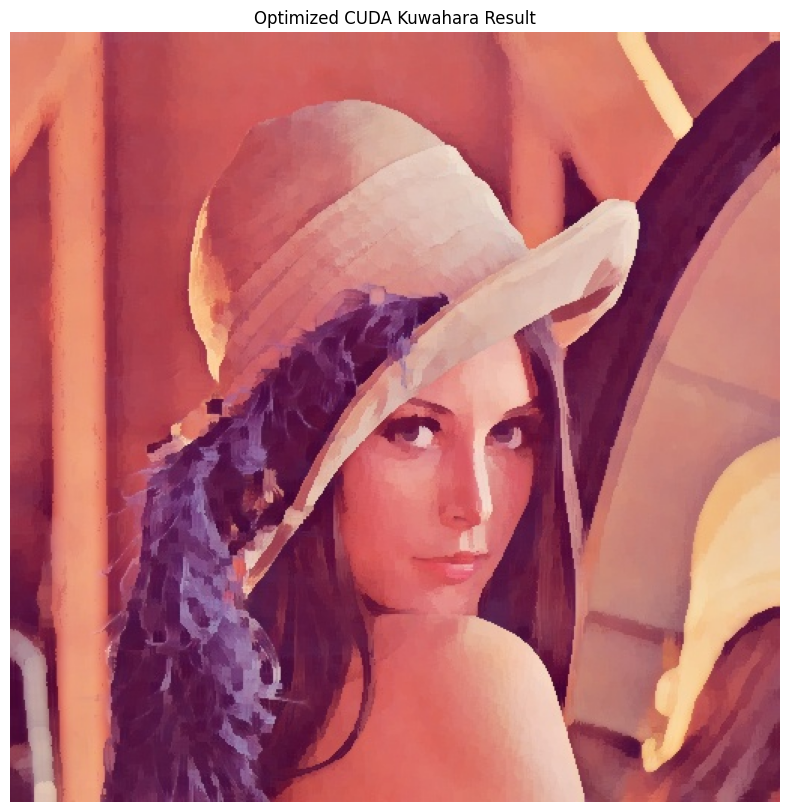

In [19]:
filtered = cv2.imread('gpu-optimizedcuda-output.jpg')
filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title("Optimized CUDA Kuwahara Result")
plt.imshow(filtered)
plt.axis('off')
plt.show()

## Benchmarking and testing different kernel times

Compiling C++ CPU
Compiling Standard GPU
Compiling Optimized GPU

K    | CPU      | GPU      | GPU(Opt) | Python  
----------------------------------------------
3    | 50.34    | 0.12     | 0.11     | 119.16  
5    | 117.28   | 0.16     | 0.15     | 81.42   
7    | 113.74   | 0.22     | 0.21     | 80.49   
9    | 148.36   | 0.30     | 0.30     | 79.94   
11   | 174.92   | 0.41     | 0.40     | 77.62   


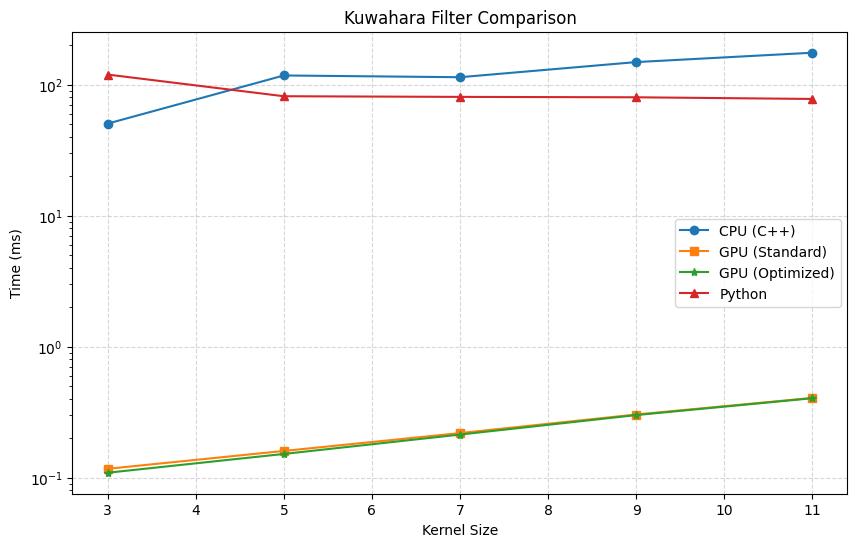

In [20]:
input_image = "test.jpg"
kernel_sizes = [3, 5, 7, 9, 11]

# compile C++ CPU
print("Compiling C++ CPU")
os.system("g++ kuwahara_cpu.cpp -o kuwahara_cpu -O3 $(pkg-config --cflags --libs opencv4)")

# get GPU Arch
try:
    cc = subprocess.check_output(['nvidia-smi', '--query-gpu=compute_cap', '--format=csv,noheader']).decode('utf-8').strip()
    arch = f"sm_{cc.replace('.', '')}"
except:
    arch = "sm_75"

# compile Standard GPU
print("Compiling Standard GPU")
os.system(f"nvcc kuwahara_gpu.cu -o kuwahara_gpu -arch={arch} $(pkg-config --cflags --libs opencv4)")

# compile Optimized GPU
print("Compiling Optimized GPU")
os.system(f"nvcc kuwahara_gpu_optimized.cu -o kuwahara_gpu_opt -arch={arch} $(pkg-config --cflags --libs opencv4)")

cpu_times = []
gpu_times = []
gpu_opt_times = []
py_times = []

print(f"\n{'K':<4} | {'CPU':<8} | {'GPU':<8} | {'GPU(Opt)':<8} | {'Python':<8}")
print("-" * 46)

img = cv2.imread(input_image)

for k in kernel_sizes:
    # CPU
    t_cpu = 0
    if os.path.exists("./kuwahara_cpu"):
        r = subprocess.run(["./kuwahara_cpu", input_image, str(k)], capture_output=True, text=True)
        m = re.search(r"CPU_TIME:([0-9.]+)", r.stdout)
        if m: t_cpu = float(m.group(1))
    cpu_times.append(t_cpu)

    # Standard GPU
    t_gpu = 0
    if os.path.exists("./kuwahara_gpu"):
        r = subprocess.run(["./kuwahara_gpu", input_image, str(k)], capture_output=True, text=True)
        m = re.search(r"GPU_TIME:([0-9.]+)", r.stdout)
        if m: t_gpu = float(m.group(1))
    gpu_times.append(t_gpu)

    # Optimized GPU
    t_gpu_opt = 0
    if os.path.exists("./kuwahara_gpu_opt"):
        r = subprocess.run(["./kuwahara_gpu_opt", input_image, str(k)], capture_output=True, text=True)
        m = re.search(r"GPU_TIME:([0-9.]+)", r.stdout)
        if m: t_gpu_opt = float(m.group(1))
    gpu_opt_times.append(t_gpu_opt)

    # Python
    s = time.perf_counter()
    kuwahara_python(img, kernel_size=k)
    t_py = (time.perf_counter() - s) * 1000.0
    py_times.append(t_py)

    print(f"{k:<4} | {t_cpu:<8.2f} | {t_gpu:<8.2f} | {t_gpu_opt:<8.2f} | {t_py:<8.2f}")

plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, cpu_times, 'o-', label='CPU (C++)')
plt.plot(kernel_sizes, gpu_times, 's-', label='GPU (Standard)')
plt.plot(kernel_sizes, gpu_opt_times, '*-', label='GPU (Optimized)')
plt.plot(kernel_sizes, py_times, '^-', label='Python')

plt.xlabel('Kernel Size')
plt.ylabel('Time (ms)')
plt.title('Kuwahara Filter Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')
plt.show()

## Report Generation for GPU Kernel

In [21]:
possible_paths = [
    "/usr/local/cuda/bin",
    "/opt/nvidia/nsight-systems/bin",
    "/usr/local/cuda-11.8/bin",
    "/usr/local/cuda-12.2/bin"
]

found = False
for path in possible_paths:
    if os.path.exists(os.path.join(path, "nsys")):
        print(f"Found nsys at: {path}")
        os.environ['PATH'] += f":{path}"
        found = True
        break
if not found:
    print("nsys not found. Attempting to install")
    !apt-get update -q
    !apt-get install -y nsight-systems-2023.3.3
    print("Installation attempt complete.")
else:
    print("nsys is ready to use.")

!nsys --version

nsys not found. Attempting to install
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.lis

In [22]:
!nsys profile \
    --trace=cuda,osrt,nvtx \
    --stats=true \
    --force-overwrite=true \
    -o kuwahara_gpu \
    ./kuwahara_gpu test.jpg 7

GPU_TIME:0.226048
Saved filtered image to: gpu-cuda-output.jpg
Generating '/tmp/nsys-report-e199.qdstrm'
[1/8] [========================100%] kuwahara_gpu.nsys-rep
[2/8] [========================100%] kuwahara_gpu.sqlite
[3/8] Executing 'nvtx_sum' stats report
SKIPPED: /content/kuwahara_gpu.sqlite does not contain NV Tools Extension (NVTX) data.
[4/8] Executing 'osrt_sum' stats report

 Time (%)  Total Time (ns)  Num Calls    Avg (ns)     Med (ns)    Min (ns)   Max (ns)    StdDev (ns)            Name         
 --------  ---------------  ---------  ------------  -----------  --------  -----------  ------------  ----------------------
     84.7      433,050,063         17  25,473,533.1  3,734,925.0     1,579  292,136,524  69,855,432.3  poll                  
     14.4       73,449,609        537     136,777.7     12,740.0       428   19,168,194   1,164,235.4  ioctl                 
      0.4        2,160,634         31      69,697.9     17,382.0     8,755    1,369,359     242,084.3  mmap

In [23]:
!nvprof ./kuwahara_gpu test.jpg 7

==3595== NVPROF is profiling process 3595, command: ./kuwahara_gpu test.jpg 7
GPU_TIME:0.228768
Saved filtered image to: gpu-cuda-output.jpg
==3595== Profiling application: ./kuwahara_gpu test.jpg 7
==3595== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  1.3621ms         2  681.03us  209.44us  1.1526ms  kuwaharaShared(unsigned char*, unsigned char*, int, int, int)
      API calls:   98.11%  104.61ms         2  52.304ms  20.034us  104.59ms  cudaMallocManaged
                    1.10%  1.1693ms         2  584.63us  10.253us  1.1590ms  cudaDeviceSynchronize
                    0.24%  250.85us         2  125.43us  17.481us  233.37us  cudaLaunchKernel
                    0.20%  211.42us         1  211.42us  211.42us  211.42us  cudaEventSynchronize
                    0.17%  181.22us       114  1.5890us     114ns  96.109us  cuDeviceGetAttribute
                    0.15%  160.15us         2  80.076us  42.909us  11

In [24]:
!nsys profile \
    --trace=cuda,osrt,nvtx \
    --stats=true \
    --force-overwrite=true \
    -o kuwahara_gpu_optimized \
    ./kuwahara_gpu_optimized test.jpg 7

GPU_TIME:0.2168
Generating '/tmp/nsys-report-71d1.qdstrm'
[1/8] [========================100%] kuwahara_gpu_optimized.nsys-rep
[2/8] [========================100%] kuwahara_gpu_optimized.sqlite
[3/8] Executing 'nvtx_sum' stats report
SKIPPED: /content/kuwahara_gpu_optimized.sqlite does not contain NV Tools Extension (NVTX) data.
[4/8] Executing 'osrt_sum' stats report

 Time (%)  Total Time (ns)  Num Calls    Avg (ns)     Med (ns)    Min (ns)   Max (ns)    StdDev (ns)            Name         
 --------  ---------------  ---------  ------------  -----------  --------  -----------  ------------  ----------------------
     88.4      425,716,781         18  23,650,932.3  6,311,408.0     2,119  275,282,994  63,680,291.1  poll                  
     10.2       48,957,864        541      90,495.1     11,508.0       457   18,584,643     809,089.7  ioctl                 
      0.4        2,060,990         31      66,483.5     11,536.0     7,639    1,294,877     229,303.0  mmap64               

In [25]:
!nvprof ./kuwahara_gpu_optimized test.jpg 7

==3680== NVPROF is profiling process 3680, command: ./kuwahara_gpu_optimized test.jpg 7
GPU_TIME:0.219744
==3680== Profiling application: ./kuwahara_gpu_optimized test.jpg 7
==3680== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  418.42us         2  209.21us  208.73us  209.69us  kuwaharaShared(unsigned char*, unsigned char*, int, int, int)
      API calls:   98.69%  120.16ms         2  60.080ms  17.501us  120.14ms  cudaMallocManaged
                    0.40%  484.82us         3  161.61us  34.162us  266.92us  cudaMemPrefetchAsync
                    0.20%  247.12us         2  123.56us  54.671us  192.45us  cudaFree
                    0.18%  216.39us         2  108.19us  3.7110us  212.68us  cudaDeviceSynchronize
                    0.17%  212.69us         1  212.69us  212.69us  212.69us  cudaEventSynchronize
                    0.17%  202.64us         2  101.32us  8.5630us  194.07us  cudaLaunchKernel
        